In [1]:
from crocoddyl import *
import pinocchio as pin
import numpy as np

robot = loadBorinotArm()
robot.initViewer(loadModel=True)

q0 = [3.14, 0]
robot.q0.flat = q0
robot.framesForwardKinematics(robot.q0)
robot.display(robot.q0)

IDX_LINK1 = robot.model.getFrameId('link1', pin.FrameType.BODY)
IDX_LINK2 = robot.model.getFrameId('link2', pin.FrameType.BODY)
Mlink1 = robot.data.oMf[IDX_LINK1]
Mlink2 = robot.data.oMf[IDX_LINK2]

target_pos  = np.array([0,0,0.3])
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

Mref = pin.SE3()
Mref.translation = target_pos.reshape(3,1)
Mref.rotation = target_quat.matrix()

robot.viewer.gui.refresh()

In [2]:
state = StatePinocchio(robot.model)

xRegCost = CostModelState(robot.model, state, ref=state.zero(), nu=1)
uRegCost = CostModelControl(robot.model, nu = 1)
xPendCost = CostModelDoublePendulum(robot.model, 
                                    frame=state, 
                                    ref=state.zero, 
                                    nu=1,
                                    activation=ActivationModelWeightedQuad(np.array([1,1,1,1]+[0.1]*2))) 

runningCostModel = CostModelSum(robot.model, nu=1)
terminalCostModel = CostModelSum(robot.model, nu=1)

# runningCostModel.addCost(name="regx", weight=1e-6, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-3, cost=uRegCost)
runningCostModel.addCost(name="pend", weight=1, cost=xPendCost)
terminalCostModel.addCost(name="ori2", weight=1e5, cost=xPendCost)

In [3]:
actModel = ActuationModelDoublePendulum(robot.model, actLink = 1)
runningModel = IntegratedActionModelEuler(DifferentialActionModelActuated(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelActuated(robot.model, actModel, terminalCostModel))

In [4]:
# Defining the time duration for running action models and the terminal one
dt = 1e-2
runningModel.timeStep = dt

T = 100
x0 = np.array([3.14, 0, 0., 0. ])
problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

In [23]:
# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

us0 = np.zeros([T,1])
#us0 = ddp.us
xs0 = [problem.initialState+0.1]*len(ddp.models())

ddp.solve(init_xs=xs0,init_us=us0,maxiter=150)
#ddp.solve(maxiter=150)

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  2.00251e+05  2.49231e+09  -2.00919e+04  1.00000e+03  1.00000e+03   0.5000     0
   1  2.00219e+05  6.36115e+08  -5.07140e+03  1.00000e+03  1.00000e+03   0.5000     0
   2  2.00207e+05  1.61402e+08  -1.25930e+03  1.00000e+03  1.00000e+03   0.5000     0
   3  2.00202e+05  4.15162e+07  -3.08384e+02  1.00000e+03  1.00000e+03   0.5000     0
   4  2.00200e+05  1.10519e+07  -7.35331e+01  1.00000e+03  1.00000e+03   0.5000     0
   5  2.00200e+05  3.15617e+06  -1.63488e+01  1.00000e+03  1.00000e+03   0.5000     0
   6  2.00199e+05  1.03152e+06  -2.80766e+00  1.00000e+03  1.00000e+03   0.5000     0
   7  2.00199e+05  4.24028e+05  1.43417e+00  1.00000e+02  1.00000e+02   1.0000     1
   8  2.00198e+05  1.23707e+05  7.82398e-01  1.00000e+02  1.00000e+02   1.0000     1
   9  2.00197e+05  1.44061e+05  9.11869e-01  1.00000e+02  1.00000e+02   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  2

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  90  3.18884e+02  2.36308e-02  5.92065e-03  1.00000e-09  1.00000e-09   1.0000     1
  91  3.18881e+02  1.48311e-02  3.73036e-03  1.00000e-09  1.00000e-09   1.0000     1
  92  3.18879e+02  9.29344e-03  2.34470e-03  1.00000e-09  1.00000e-09   1.0000     1
  93  3.18877e+02  5.81606e-03  1.47096e-03  1.00000e-09  1.00000e-09   1.0000     1
  94  3.18877e+02  3.63627e-03  9.21431e-04  1.00000e-09  1.00000e-09   1.0000     1
  95  3.18876e+02  2.27165e-03  5.76518e-04  1.00000e-09  1.00000e-09   1.0000     1
  96  3.18876e+02  1.41829e-03  3.60379e-04  1.00000e-09  1.00000e-09   1.0000     1
  97  3.18876e+02  8.85065e-04  2.25106e-04  1.00000e-09  1.00000e-09   1.0000     1
  98  3.18876e+02  5.52110e-04  1.40528e-04  1.00000e-09  1.00000e-09   1.0000     1
  99  3.18875e+02  3.44304e-04  8.76879e-05  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
 100  3.18875e

([array([3.14, 0.  , 0.  , 0.  ]),
  array([ 3.17269079, -0.05672873,  3.26907942, -5.6728731 ]),
  array([ 3.20808333, -0.11791405,  3.53925368, -6.11853221]),
  array([ 3.24602991, -0.18303993,  3.79465829, -6.51258806]),
  array([ 3.28631146, -0.25143034,  4.02815487, -6.83904043]),
  array([ 3.32863628, -0.32225426,  4.23248143, -7.08239242]),
  array([ 3.37265336, -0.39456111,  4.40170846, -7.23068519]),
  array([ 3.41797962, -0.46734364,  4.53262634, -7.27825265]),
  array([ 3.46423776, -0.53961941,  4.62581357, -7.22757736]),
  array([ 3.51109735, -0.6105138 ,  4.68595932, -7.08943814]),
  array([ 3.55831017, -0.67932569,  4.72128149, -6.8811892 ]),
  array([ 3.60573282, -0.74556377,  4.74226543, -6.62380789]),
  array([ 3.65333474, -0.80895137,  4.76019217, -6.33875985]),
  array([ 3.70119372, -0.86940691,  4.78589762, -6.04555448]),
  array([ 3.74948362, -0.92701044,  4.82898998, -5.76035323]),
  array([ 3.79845891, -0.98196575,  4.89752875, -5.49553029]),
  array([ 3.84843933

In [24]:
displayTrajectory(robot, ddp.xs, runningModel.timeStep)

In [19]:
import time 
dt = 0.01
t = np.arange(0,1,dt)
q0 = np.array([[3.14,0]]).T

q = q0
q_d = np.zeros([2,1])
q_dd = np.zeros([2,1])

In [8]:
nle = np.zeros([2,1])
for i in range(len(t)):
    pin.computeAllTerms(robot.model, robot.data, q, q_d)
    M = robot.data.M
    Minv = np.linalg.inv(M)
    r = np.zeros([2,1])
    tau = np.zeros([2,1])
    tau[0,0] = ddp.us[i]
    nle[:,0] = m2a(robot.data.nle)    
    r[:] = tau - nle
    q_dd = np.dot(Minv, r)
    q = q + q_d*dt + q_dd*dt**2
    q_d = q_d + q_dd*dt
    #pin.forwardKinematics(robot.model, robot.data, q, q_d)
    robot.display(q)
    time.sleep(dt)

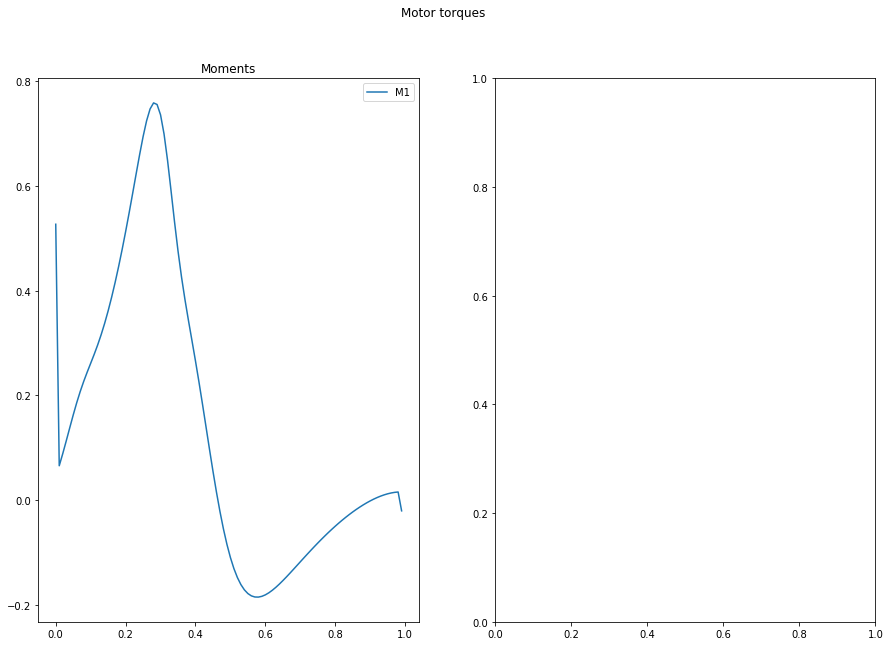

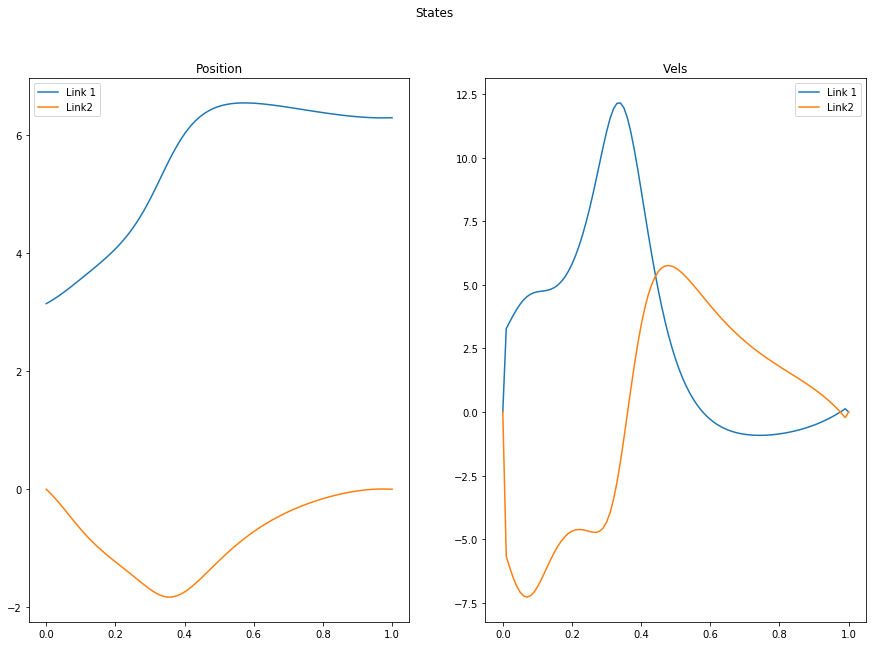

In [9]:
import numpy as np
import matplotlib.pyplot as plt

control = np.vstack(ddp.us)
t = np.arange(0,T*dt, dt)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('Motor torques')
# axs[0].plot(t,control[:,0], t,control[:,1])
axs[0].plot(t,control[:,0])
axs[0].set_title('Moments')
axs[0].legend(['M1','M2'])

t_state = np.append(t, t[-1]+dt)
state = np.vstack(ddp.xs)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('States')
axs[0].plot(t_state,state[:,0], t_state, state[:,1])
axs[0].set_title('Position')
axs[0].legend(['Link 1','Link2'])
axs[1].plot(t_state,state[:,2], t_state, state[:,3])
axs[1].set_title('Vels')
axs[1].legend(['Link 1','Link2'])